In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [7]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

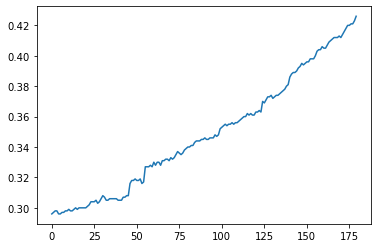

In [8]:
df = df[:180]
df.plot()

In [9]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [11]:
train = df_scaled

In [12]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [14]:
x_train.shape

(128, 20, 1)

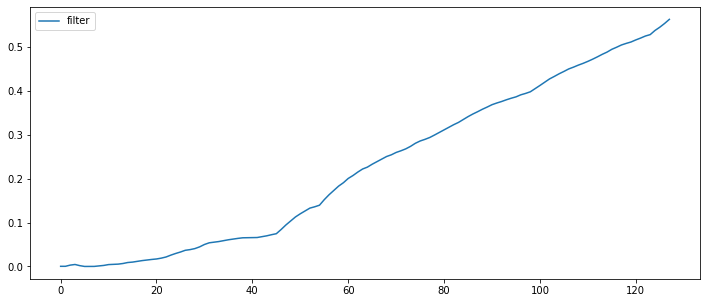

In [15]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

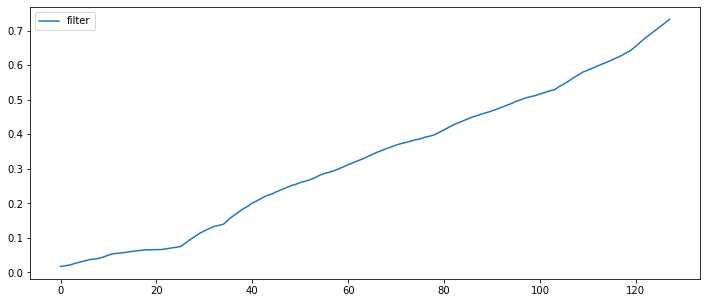

In [16]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [17]:
OUT_STEPS = 20

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [19]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
8/8 [==============================] - 1s 4ms/step - loss: 0.1122 - mean_absolute_error: 0.2631
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0889 - mean_absolute_error: 0.2311
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0907 - mean_absolute_error: 0.2394
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0653 - mean_absolute_error: 0.1949
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0647 - mean_absolute_error: 0.1987
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0435 - mean_absolute_error: 0.1629
Epoch 7/1000
8/8 [==============================] - 0s 5ms/step - loss: 0.0346 - mean_absolute_error: 0.1493
Epoch 8/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0298 - mean_absolute_error: 0.1401
Epoch 9/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0214 - mean_absolute_error: 0.1201
Epoch 10/1000
8/8 [

8/8 [==============================] - 0s 4ms/step - loss: 6.7356e-05 - mean_absolute_error: 0.0060
Epoch 74/1000
8/8 [==============================] - 0s 4ms/step - loss: 7.0277e-05 - mean_absolute_error: 0.0061
Epoch 75/1000
8/8 [==============================] - ETA: 0s - loss: 4.7506e-05 - mean_absolute_error: 0.005 - 0s 4ms/step - loss: 6.0878e-05 - mean_absolute_error: 0.0057
Epoch 76/1000
8/8 [==============================] - 0s 5ms/step - loss: 6.1965e-05 - mean_absolute_error: 0.0057
Epoch 77/1000
8/8 [==============================] - 0s 6ms/step - loss: 6.1121e-05 - mean_absolute_error: 0.0058
Epoch 78/1000
8/8 [==============================] - 0s 4ms/step - loss: 5.7372e-05 - mean_absolute_error: 0.0057
Epoch 79/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.8896e-05 - mean_absolute_error: 0.0056
Epoch 80/1000
8/8 [==============================] - 0s 5ms/step - loss: 5.9929e-05 - mean_absolute_error: 0.0056
Epoch 81/1000
8/8 [=========================

8/8 [==============================] - 0s 5ms/step - loss: 3.6425e-05 - mean_absolute_error: 0.0047
Epoch 145/1000
8/8 [==============================] - 0s 6ms/step - loss: 3.3944e-05 - mean_absolute_error: 0.0045
Epoch 146/1000
8/8 [==============================] - 0s 8ms/step - loss: 3.8013e-05 - mean_absolute_error: 0.0049
Epoch 147/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.8340e-05 - mean_absolute_error: 0.0049
Epoch 148/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.5792e-05 - mean_absolute_error: 0.0047
Epoch 149/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.4679e-05 - mean_absolute_error: 0.0047
Epoch 150/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.5392e-05 - mean_absolute_error: 0.0047
Epoch 151/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.2764e-05 - mean_absolute_error: 0.0045
Epoch 152/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.1514e-05 - mean_abs

8/8 [==============================] - 0s 9ms/step - loss: 2.7973e-05 - mean_absolute_error: 0.0042
Epoch 216/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.7201e-05 - mean_absolute_error: 0.0041
Epoch 217/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.6355e-05 - mean_absolute_error: 0.0041
Epoch 218/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.5404e-05 - mean_absolute_error: 0.0039
Epoch 219/1000
8/8 [==============================] - 0s 8ms/step - loss: 2.6449e-05 - mean_absolute_error: 0.0040
Epoch 220/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.0701e-05 - mean_absolute_error: 0.0044
Epoch 221/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.5132e-05 - mean_absolute_error: 0.0039
Epoch 222/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.6627e-05 - mean_absolute_error: 0.0040
Epoch 223/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.7220e-05 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 2.3113e-05 - mean_absolute_error: 0.0038
Epoch 287/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1206e-05 - mean_absolute_error: 0.0036
Epoch 288/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.0741e-05 - mean_absolute_error: 0.0035
Epoch 289/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.2238e-05 - mean_absolute_error: 0.0037
Epoch 290/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.2569e-05 - mean_absolute_error: 0.0037
Epoch 291/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1591e-05 - mean_absolute_error: 0.0036
Epoch 292/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.0556e-05 - mean_absolute_error: 0.0035
Epoch 293/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.3394e-05 - mean_absolute_error: 0.0038
Epoch 294/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1745e-05 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 2.0727e-05 - mean_absolute_error: 0.0036
Epoch 357/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.2432e-05 - mean_absolute_error: 0.0037
Epoch 358/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.3403e-05 - mean_absolute_error: 0.0038
Epoch 359/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1741e-05 - mean_absolute_error: 0.0037
Epoch 360/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.0281e-05 - mean_absolute_error: 0.0036
Epoch 361/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.0857e-05 - mean_absolute_error: 0.0036
Epoch 362/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1977e-05 - mean_absolute_error: 0.0037
Epoch 363/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.9633e-05 - mean_absolute_error: 0.0035
Epoch 364/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9911e-05 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.9855e-05 - mean_absolute_error: 0.0035
Epoch 428/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.0542e-05 - mean_absolute_error: 0.0036
Epoch 429/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8878e-05 - mean_absolute_error: 0.0034
Epoch 430/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.8697e-05 - mean_absolute_error: 0.0034
Epoch 431/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.9090e-05 - mean_absolute_error: 0.0035
Epoch 432/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.9593e-05 - mean_absolute_error: 0.0035
Epoch 433/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9902e-05 - mean_absolute_error: 0.0035
Epoch 434/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8268e-05 - mean_absolute_error: 0.0034
Epoch 435/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6496e-05 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.7955e-05 - mean_absolute_error: 0.0034
Epoch 499/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7736e-05 - mean_absolute_error: 0.0033
Epoch 500/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6682e-05 - mean_absolute_error: 0.0032
Epoch 501/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6707e-05 - mean_absolute_error: 0.0032
Epoch 502/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8328e-05 - mean_absolute_error: 0.0034
Epoch 503/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.8427e-05 - mean_absolute_error: 0.0034
Epoch 504/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8437e-05 - mean_absolute_error: 0.0034
Epoch 505/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7333e-05 - mean_absolute_error: 0.0033
Epoch 506/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8293e-05 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 1.7321e-05 - mean_absolute_error: 0.0033
Epoch 569/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6477e-05 - mean_absolute_error: 0.0032
Epoch 570/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6203e-05 - mean_absolute_error: 0.0032
Epoch 571/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.6345e-05 - mean_absolute_error: 0.0032
Epoch 572/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8052e-05 - mean_absolute_error: 0.0034
Epoch 573/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6590e-05 - mean_absolute_error: 0.0032
Epoch 574/1000
8/8 [==============================] - ETA: 0s - loss: 1.6388e-05 - mean_absolute_error: 0.003 - 0s 6ms/step - loss: 1.6773e-05 - mean_absolute_error: 0.0032
Epoch 575/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7321e-05 - mean_absolute_error: 0.0033
Epoch 576/1000
8/8 [=================

8/8 [==============================] - 0s 5ms/step - loss: 1.7419e-05 - mean_absolute_error: 0.0033
Epoch 639/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.6233e-05 - mean_absolute_error: 0.0032
Epoch 640/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.0424e-05 - mean_absolute_error: 0.0036
Epoch 641/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7116e-05 - mean_absolute_error: 0.0032
Epoch 642/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7736e-05 - mean_absolute_error: 0.0033
Epoch 643/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.8285e-05 - mean_absolute_error: 0.0034
Epoch 644/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.6305e-05 - mean_absolute_error: 0.0032
Epoch 645/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6450e-05 - mean_absolute_error: 0.0032
Epoch 646/1000
8/8 [==============================] - 0s 8ms/step - loss: 1.8573e-05 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 1.7637e-05 - mean_absolute_error: 0.0033
Epoch 710/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7898e-05 - mean_absolute_error: 0.0034
Epoch 711/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7945e-05 - mean_absolute_error: 0.0034
Epoch 712/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8604e-05 - mean_absolute_error: 0.0035
Epoch 713/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7402e-05 - mean_absolute_error: 0.0033
Epoch 714/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.5825e-05 - mean_absolute_error: 0.0032
Epoch 715/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.7141e-05 - mean_absolute_error: 0.0033
Epoch 716/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6984e-05 - mean_absolute_error: 0.0032
Epoch 717/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6288e-05 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 1.8421e-05 - mean_absolute_error: 0.0033
Epoch 781/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6561e-05 - mean_absolute_error: 0.0032
Epoch 782/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6540e-05 - mean_absolute_error: 0.0033
Epoch 783/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8033e-05 - mean_absolute_error: 0.0034
Epoch 784/1000
8/8 [==============================] - ETA: 0s - loss: 1.9771e-05 - mean_absolute_error: 0.003 - 0s 5ms/step - loss: 1.9103e-05 - mean_absolute_error: 0.0035
Epoch 785/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8513e-05 - mean_absolute_error: 0.0035
Epoch 786/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.0796e-05 - mean_absolute_error: 0.0036
Epoch 787/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1867e-05 - mean_absolute_error: 0.0037
Epoch 788/1000
8/8 [=================

8/8 [==============================] - 0s 4ms/step - loss: 1.8834e-05 - mean_absolute_error: 0.0035
Epoch 851/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.7724e-05 - mean_absolute_error: 0.0033
Epoch 852/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6821e-05 - mean_absolute_error: 0.0032
Epoch 853/1000
8/8 [==============================] - 0s 2ms/step - loss: 1.6956e-05 - mean_absolute_error: 0.0033
Epoch 854/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5252e-05 - mean_absolute_error: 0.0031
Epoch 855/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5519e-05 - mean_absolute_error: 0.0031
Epoch 856/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4476e-05 - mean_absolute_error: 0.0030
Epoch 857/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5180e-05 - mean_absolute_error: 0.0031
Epoch 858/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4443e-05 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 1.7100e-05 - mean_absolute_error: 0.0033
Epoch 921/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4273e-05 - mean_absolute_error: 0.0030
Epoch 922/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6588e-05 - mean_absolute_error: 0.0033
Epoch 923/1000
8/8 [==============================] - 0s 10ms/step - loss: 1.3591e-05 - mean_absolute_error: 0.0029
Epoch 924/1000
8/8 [==============================] - 0s 8ms/step - loss: 1.5960e-05 - mean_absolute_error: 0.0032
Epoch 925/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7241e-05 - mean_absolute_error: 0.0033
Epoch 926/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6450e-05 - mean_absolute_error: 0.0032
Epoch 927/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.4772e-05 - mean_absolute_error: 0.0031
Epoch 928/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.6131e-05 - mean_ab

8/8 [==============================] - 0s 4ms/step - loss: 1.6024e-05 - mean_absolute_error: 0.0032
Epoch 991/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5049e-05 - mean_absolute_error: 0.0031
Epoch 992/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4437e-05 - mean_absolute_error: 0.0030
Epoch 993/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4979e-05 - mean_absolute_error: 0.0031
Epoch 994/1000
8/8 [==============================] - ETA: 0s - loss: 1.5002e-05 - mean_absolute_error: 0.003 - 0s 4ms/step - loss: 1.6733e-05 - mean_absolute_error: 0.0032
Epoch 995/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.6662e-05 - mean_absolute_error: 0.0033
Epoch 996/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.4502e-05 - mean_absolute_error: 0.0030
Epoch 997/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5866e-05 - mean_absolute_error: 0.0032
Epoch 998/1000
8/8 [=================

num 0 14.964673610834053 actual 0.6190476190476186 prediction 0.7116861
num 1 7.964590191841221 actual 0.6666666666666661 prediction 0.71976393
num 2 2.7915883064271116 actual 0.7142857142857135 prediction 0.73422563
num 3 2.746003493666757 actual 0.7619047619047628 prediction 0.74098283
num 4 4.912865161895864 actual 0.7142857142857135 prediction 0.7493776
num 5 13.986963033676247 actual 0.6666666666666661 prediction 0.7599131
num 6 17.033961415290936 actual 0.6666666666666661 prediction 0.7802264
num 7 16.018620133400066 actual 0.6666666666666661 prediction 0.77345747
num 8 11.941864490509152 actual 0.7142857142857135 prediction 0.79958475
num 9 11.557768583297849 actual 0.7142857142857135 prediction 0.7968412
num 10 13.663557767868163 actual 0.7142857142857135 prediction 0.81188256
num 11 23.81555140018474 actual 0.6666666666666661 prediction 0.825437
num 12 17.063769102096682 actual 0.7142857142857135 prediction 0.8361698
num 13 11.629422008991117 actual 0.7619047619047628 predicti

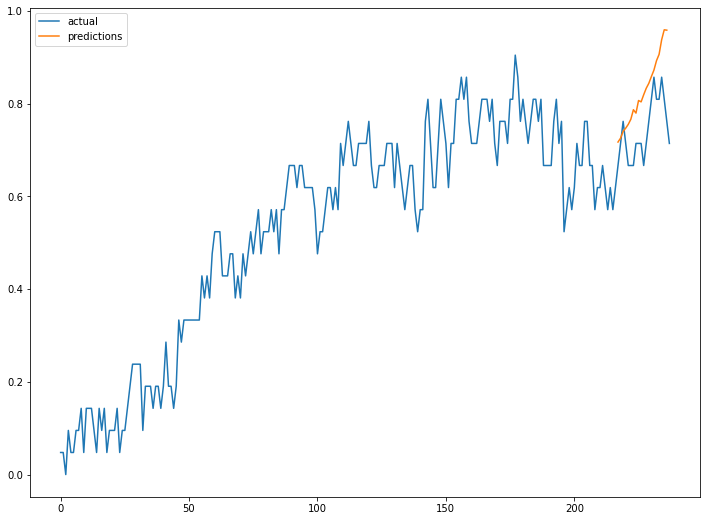

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 9.983193825702259 actual 0.8006535947712417 prediction 0.7207228
num 1 10.348392734604497 actual 0.8104575163398693 prediction 0.7265882
num 2 9.392878520919616 actual 0.8137254901960784 prediction 0.73729324
num 3 8.674178075790403 actual 0.8169934640522876 prediction 0.746126
num 4 7.640652990341184 actual 0.8169934640522876 prediction 0.7545698
num 5 7.0520944804309345 actual 0.8202614379084967 prediction 0.7624158
num 6 5.02527085217562 actual 0.826797385620915 prediction 0.7852486
num 7 6.8566525354981325 actual 0.8366013071895424 prediction 0.77923846
num 8 4.0653605718870285 actual 0.8464052287581698 prediction 0.8119958
num 9 5.786062931192316 actual 0.8529411764705881 prediction 0.80358946
num 10 4.8503546660390455 actual 0.8594771241830064 prediction 0.81778944
num 11 3.43333591114389 actual 0.8627450980392155 prediction 0.83312416
num 12 2.854354291591983 actual 0.8660130718954246 prediction 0.841294
num 13 1.120312033959133 actual 0.8660130718954246 prediction 0.85631

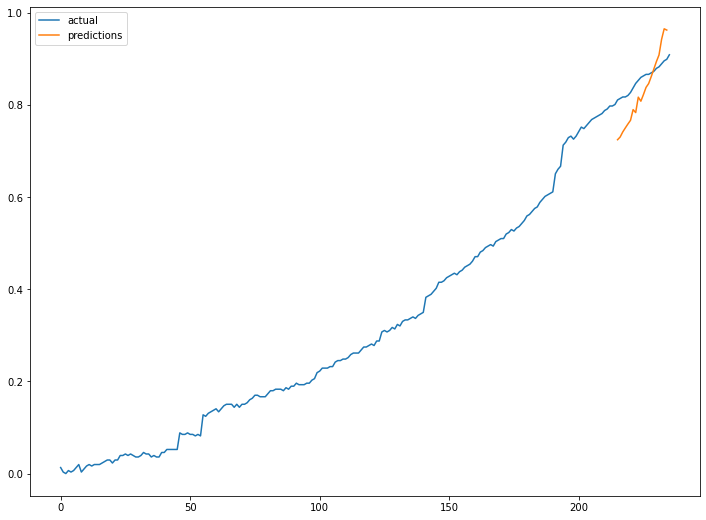

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.3459297478429044 actual 0.6762402088772845 prediction 0.6536137
num 1 4.03949767351149 actual 0.6892950391644908 prediction 0.661451
num 2 3.7105844485179063 actual 0.6971279373368144 prediction 0.6712604
num 3 3.374288582890429 actual 0.702349869451697 prediction 0.67865056
num 4 3.0892033198662614 actual 0.7075718015665795 prediction 0.68571347
num 5 3.003992499226204 actual 0.7154046997389034 prediction 0.693914
num 6 2.684901756197745 actual 0.7284595300261096 prediction 0.7089011
num 7 4.182404174400306 actual 0.7389033942558747 prediction 0.70799947
num 8 3.029875929762659 actual 0.7493472584856395 prediction 0.72664297
num 9 3.68872154955219 actual 0.7545691906005221 prediction 0.72673523
num 10 3.5810191680139978 actual 0.7650130548302871 prediction 0.7376178
num 11 2.422764512146419 actual 0.7676240208877285 prediction 0.7490263
num 12 1.3006156196399687 actual 0.7676240208877285 prediction 0.7576402
num 13 1.175656274661108 actual 0.7780678851174934 prediction 0.76892

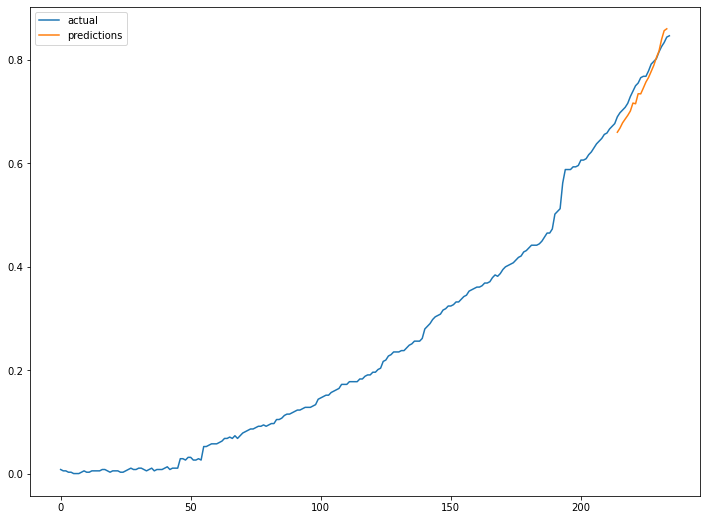

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.286987204300659 actual 0.7916666666666661 prediction 0.74981135
num 1 4.293986370688919 actual 0.7916666666666661 prediction 0.7576726
num 2 2.40303089744159 actual 0.7916666666666661 prediction 0.7726427
num 3 4.038898150126139 actual 0.75 prediction 0.78029174
num 4 0.36975459048615084 actual 0.7916666666666661 prediction 0.78873944
num 5 6.658824284871419 actual 0.75 prediction 0.7999412
num 6 1.0792803764343966 actual 0.8333333333333339 prediction 0.82433933
num 7 2.2870182991028525 actual 0.8333333333333339 prediction 0.81427485
num 8 7.260630347511925 actual 0.9166666666666661 prediction 0.8501109
num 9 12.13026046752935 actual 0.9583333333333339 prediction 0.842085
num 10 10.370812208756213 actual 0.9583333333333339 prediction 0.8589464
num 11 8.606643262116862 actual 0.9583333333333339 prediction 0.875853
num 12 7.628328903861725 actual 0.9583333333333339 prediction 0.8852285
num 13 5.9244529060696065 actual 0.9583333333333339 prediction 0.9015573
num 14 0.2646727995439

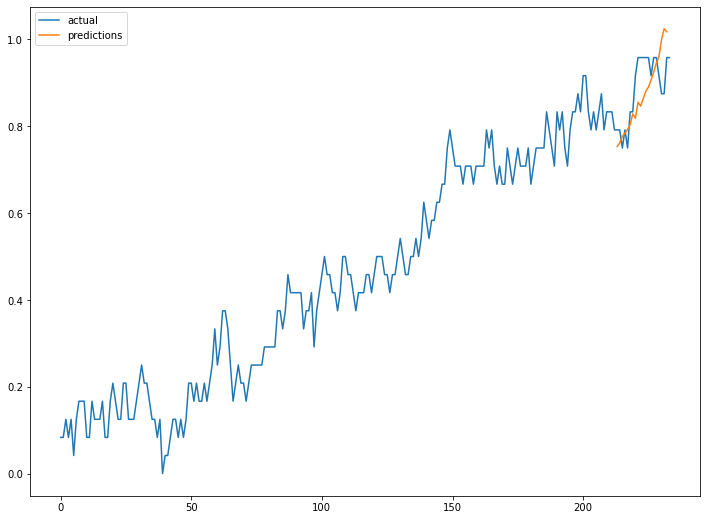

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 11.044208125064234 actual 0.8482142857142856 prediction 0.75453573
num 1 11.396420001983603 actual 0.8571428571428568 prediction 0.75945926
num 2 9.101137863962261 actual 0.8482142857142856 prediction 0.77101713
num 3 8.483907689598816 actual 0.8526785714285712 prediction 0.7803381
num 4 8.844224202264195 actual 0.8660714285714284 prediction 0.7894741
num 5 8.862113952636719 actual 0.875 prediction 0.7974565
num 6 6.221569855201049 actual 0.8794642857142856 prediction 0.8247478
num 7 8.200031069654875 actual 0.8883928571428568 prediction 0.81554437
num 8 3.0952993065419547 actual 0.8839285714285712 prediction 0.85656834
num 9 5.092520210611121 actual 0.8883928571428568 prediction 0.8431513
num 10 2.7922822971536374 actual 0.8839285714285712 prediction 0.8592468
num 11 1.7826318740844658 actual 0.8928571428571428 prediction 0.8769408
num 12 1.8921880438775955 actual 0.901785714285714 prediction 0.88472223
num 13 0.5047831042059536 actual 0.90625 prediction 0.9016754
num 14 1.57629

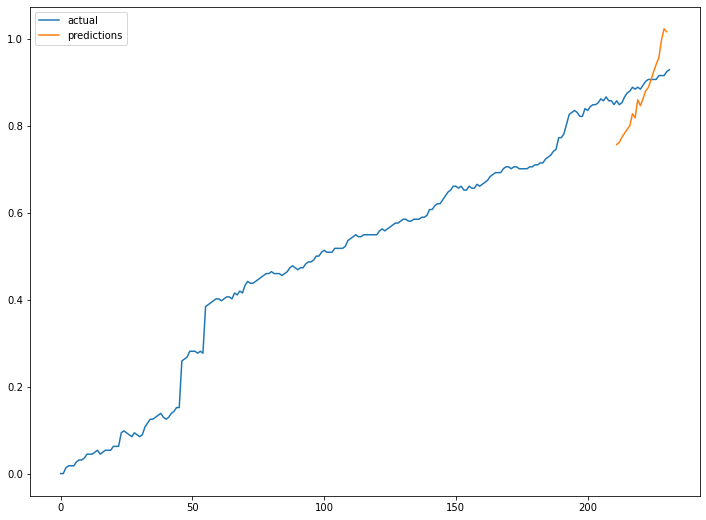

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.643278346342345 actual 0.8500000000000014 prediction 0.74253213
num 1 6.780458986759269 actual 0.8000000000000007 prediction 0.7457563
num 2 0.5484342575073242 actual 0.75 prediction 0.75411326
num 3 1.9481182098388672 actual 0.75 prediction 0.7646109
num 4 3.1902313232421875 actual 0.75 prediction 0.77392673
num 5 3.8961172103881836 actual 0.75 prediction 0.7792209
num 6 15.223297051020857 actual 0.7000000000000011 prediction 0.8065631
num 7 14.198437758854283 actual 0.7000000000000011 prediction 0.79938906
num 8 29.315018653869558 actual 0.6500000000000004 prediction 0.8405476
num 9 17.92537144252214 actual 0.7000000000000011 prediction 0.8254776
num 10 12.002229690551758 actual 0.75 prediction 0.8400167
num 11 14.307006200154623 actual 0.75 prediction 0.85730255
num 12 23.412941183362502 actual 0.7000000000000011 prediction 0.8638906
num 13 25.76970883778144 actual 0.7000000000000011 prediction 0.88038796
num 14 12.375855445861717 actual 0.8000000000000007 prediction 0.8990

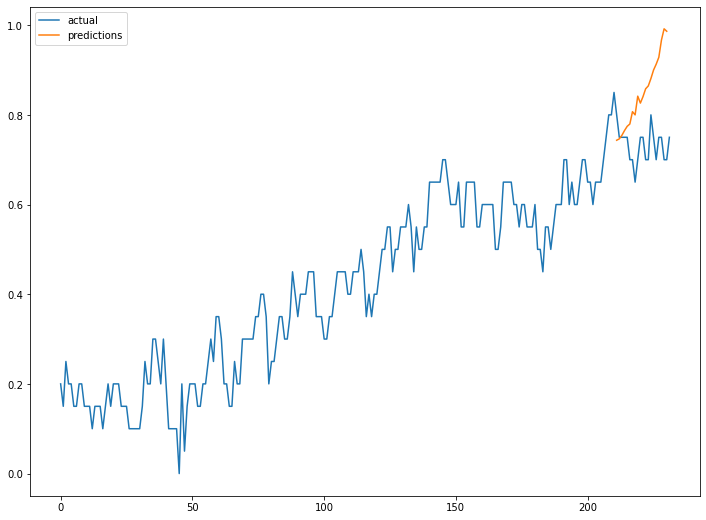

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 12.167842313647173 actual 0.8421052631578938 prediction 0.7396392
num 1 14.287482608448357 actual 0.8684210526315788 prediction 0.74434555
num 2 10.288562998175522 actual 0.8421052631578938 prediction 0.75546473
num 3 11.967885855472431 actual 0.8684210526315788 prediction 0.7644894
num 4 10.890656167810594 actual 0.8684210526315788 prediction 0.7738443
num 5 7.252800837159054 actual 0.8421052631578938 prediction 0.78102905
num 6 1.0824630337375785 actual 0.8157894736842097 prediction 0.80695885
num 7 2.0576523196311736 actual 0.8157894736842097 prediction 0.79900336
num 8 0.6686557084320873 actual 0.8421052631578938 prediction 0.8364745
num 9 2.068467810749899 actual 0.8421052631578938 prediction 0.8246866
num 10 3.264857783462041 actual 0.8684210526315788 prediction 0.84006834
num 11 1.6911666840315993 actual 0.8421052631578938 prediction 0.85634667
num 12 3.378207543316974 actual 0.8947368421052628 prediction 0.8645108
num 13 1.4186674898321197 actual 0.8684210526315788 predic

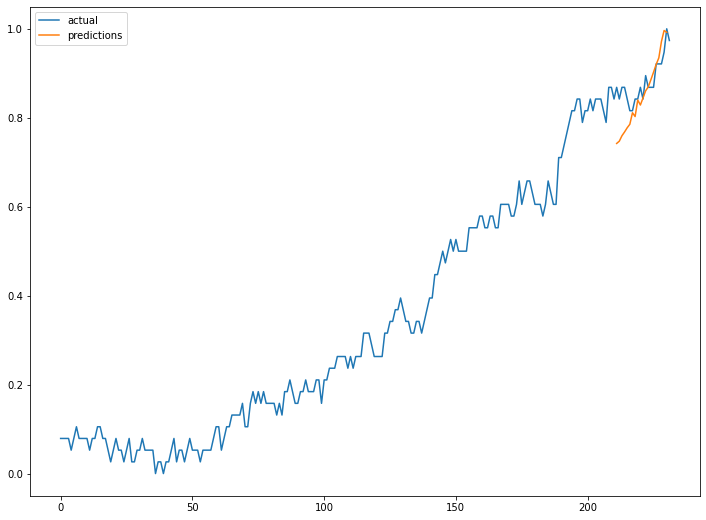

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.743073463440041 actual 0.76923076923077 prediction 0.717361
num 1 1.0484450741819373 actual 0.7307692307692317 prediction 0.7231075
num 2 0.46900071595831316 actual 0.7307692307692317 prediction 0.73419654
num 3 1.6230043612027092 actual 0.7307692307692317 prediction 0.74262965
num 4 8.536716964509859 actual 0.6923076923076916 prediction 0.75140804
num 5 1.3219100236893753 actual 0.76923076923077 prediction 0.75906223
num 6 3.212315127963193 actual 0.8076923076923084 prediction 0.7817467
num 7 3.9582621483576546 actual 0.8076923076923084 prediction 0.7757217
num 8 4.585509950464484 actual 0.8461538461538467 prediction 0.8073534
num 9 1.0276663871039367 actual 0.8076923076923084 prediction 0.7993919
num 10 5.778189897537119 actual 0.76923076923077 prediction 0.8136784
num 11 7.693954706191902 actual 0.76923076923077 prediction 0.82841504
num 12 8.809583187103156 actual 0.76923076923077 prediction 0.8369968
num 13 5.472216719672704 actual 0.8076923076923084 prediction 0.851891
nu

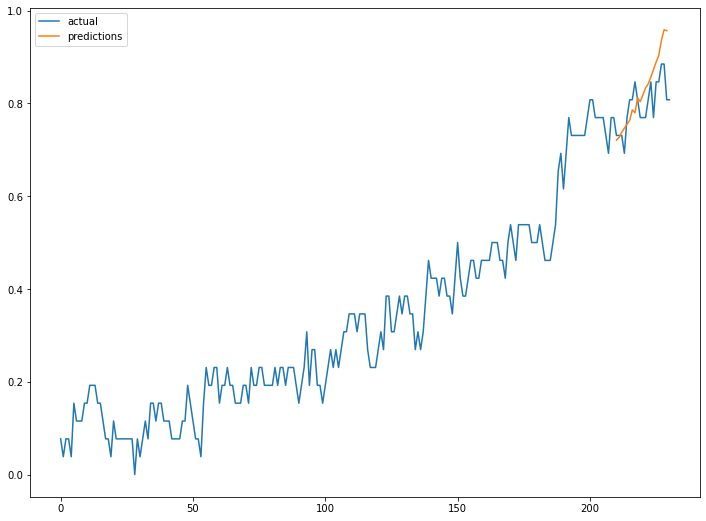

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 6.1562575101852115 actual 0.7389162561576352 prediction 0.69342667
num 1 6.564694839088538 actual 0.7487684729064039 prediction 0.6996141
num 2 5.887986281338815 actual 0.7536945812807878 prediction 0.70931715
num 3 5.368924411860347 actual 0.7586206896551722 prediction 0.7178909
num 4 5.539998679588996 actual 0.7684729064039408 prediction 0.7258995
num 5 5.191300856839327 actual 0.7733990147783252 prediction 0.73324955
num 6 3.2390989457504307 actual 0.7783251231527091 prediction 0.7531144
num 7 4.309267068059167 actual 0.7832512315270934 prediction 0.74949884
num 8 1.4490915089845564 actual 0.7881773399014778 prediction 0.7767559
num 9 2.742101316866671 actual 0.7931034482758621 prediction 0.77135575
num 10 1.7596629666693038 actual 0.798029556650246 prediction 0.7839869
num 11 0.04911783300796225 actual 0.798029556650246 prediction 0.7976376
num 12 0.252176457788874 actual 0.8078817733990147 prediction 0.8058445
num 13 0.3977494682380264 actual 0.8226600985221673 prediction 0.

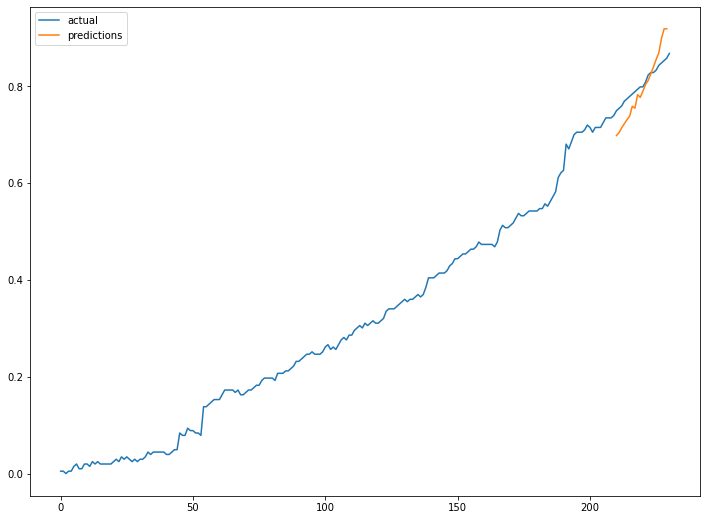

In [28]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()